In [1]:
import torch

Importing `torch` takes time

In [2]:
from constants import DataSplit
from model import TransformerDecoder
from train import train_transformer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Hyper Parameters

In [4]:
# --------------------------------------------------------------------------------------------------- #

dataset_path = 'data/tinyshakespeare.txt'
percent_train = 0.90

batch_size = 64
context_length = 256

n_embd = 384
n_layer = 6
num_head = 6
dropout = 0.2

learning_rate = 3e-4
max_iters = 5000
device = 'cuda' if torch.cuda.is_available() else 'cpu'

eval_intervals = 300
eval_iters = 200

# --------------------------------------------------------------------------------------------------- #

In [5]:
f'Running on device: {device}, cuda version: {torch.version.cuda}'

'Running on device: cpu, cuda version: 11.8'

## Loading the Dataset

### Opening and Reading the File

In [6]:
with open(dataset_path, 'r') as fp:
    dataset = fp.read()

### Vocabulary
Creating a vocabulary. Essentially contains all the *tokens* which is recognised by the language model.

In [7]:
vocabulary = sorted(list(set(dataset)))
vocab_size = len(vocabulary)

### Encoders and Decoder
We are using a simple method to encode and decode the text data into numbers (integers).

In [8]:
stoi = {ch: i for i, ch in enumerate(vocabulary)}
itos = {i: ch for i, ch in enumerate(vocabulary)}

def encode(x): return [stoi[ch] for ch in x]
def decode(x): return ''.join([itos[i] for i in x])

test_text = 'This is a sample sentence.'
assert (test_text == decode(encode(test_text)))

### Encoding All the Dataset
We encode all the dataset into numbers.

In [9]:
encoded_dataset = torch.tensor(encode(dataset), dtype=torch.long)

### Split Dataset
We split the dataset to train the model and validate the model. Validation is important as we are trying to generalise the model so that it can produce sentences which are "like" the training data but not exactly the training data.

In [10]:
idx = int(len(encoded_dataset) * percent_train)
train_data, val_data = encoded_dataset[:idx], encoded_dataset[idx:]

In [11]:
def get_data(split: DataSplit) -> torch.Tensor:
    return train_data if split == DataSplit.TRAIN else val_data

## Training and Testing the Model

In [12]:
model = TransformerDecoder(
    vocabulary_size=vocab_size,
    embedding_dim=n_embd,
    context_length=context_length,
    number_of_layers=n_layer,
    number_of_heads=num_head,
    dropout=dropout,
    device=device
).to(device)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
all_losses = train_transformer(
    model=model,
    optimizer=optimizer,
    get_data=get_data,
    batch_size=batch_size,
    context_length=context_length,
    maximum_iterations=max_iters,
    eval_intervals=eval_intervals,
    eval_iterations=eval_iters
)

  0%|          | 4/5000 [00:03<1:03:31,  1.31it/s]

Iteration[   1/5000], Training Loss:  4.325428, Validation Loss:  4.329978


 10%|█         | 503/5000 [00:25<22:48,  3.29it/s]

Iteration[ 501/5000], Training Loss:  2.548220, Validation Loss:  2.550921


 20%|██        | 1005/5000 [00:45<16:51,  3.95it/s]

Iteration[1001/5000], Training Loss:  2.438302, Validation Loss:  2.448859


 30%|███       | 1503/5000 [01:06<18:30,  3.15it/s]

Iteration[1501/5000], Training Loss:  2.371189, Validation Loss:  2.380672


 40%|████      | 2004/5000 [01:27<13:05,  3.81it/s]

Iteration[2001/5000], Training Loss:  2.311938, Validation Loss:  2.319304


 50%|█████     | 2503/5000 [01:48<14:45,  2.82it/s]

Iteration[2501/5000], Training Loss:  2.246067, Validation Loss:  2.268588


 60%|██████    | 3004/5000 [02:10<09:55,  3.35it/s]

Iteration[3001/5000], Training Loss:  2.185260, Validation Loss:  2.206081


 70%|███████   | 3504/5000 [02:31<07:01,  3.55it/s]

Iteration[3501/5000], Training Loss:  2.139150, Validation Loss:  2.170822


 80%|████████  | 4005/5000 [02:52<04:45,  3.49it/s]

Iteration[4001/5000], Training Loss:  2.096445, Validation Loss:  2.132046


 90%|█████████ | 4505/5000 [03:13<02:21,  3.51it/s]

Iteration[4501/5000], Training Loss:  2.069629, Validation Loss:  2.103683


100%|██████████| 5000/5000 [03:31<00:00, 23.63it/s]

Final Loss:
	Training:  2.069629
	Validation:  2.103683


In [15]:
generate_next_tokens = 100
prompt = 'What is life?'

idx = torch.tensor([encode(prompt)], dtype=torch.long, device=device)
# idx = torch.zeros((1, 1), dtype=torch.long, device=device)
generation = decode(model.generate(idx, max_next_tokens=generate_next_tokens)[0].tolist())
print(f'User: {prompt}\nModel: {generation}')

User: What is life?
Model: What is life?
Godry! I I whink tat make happst?

ARERT:
Yet bato hadd, hat the uld I ram to-dy ve,
Jerfor mothass


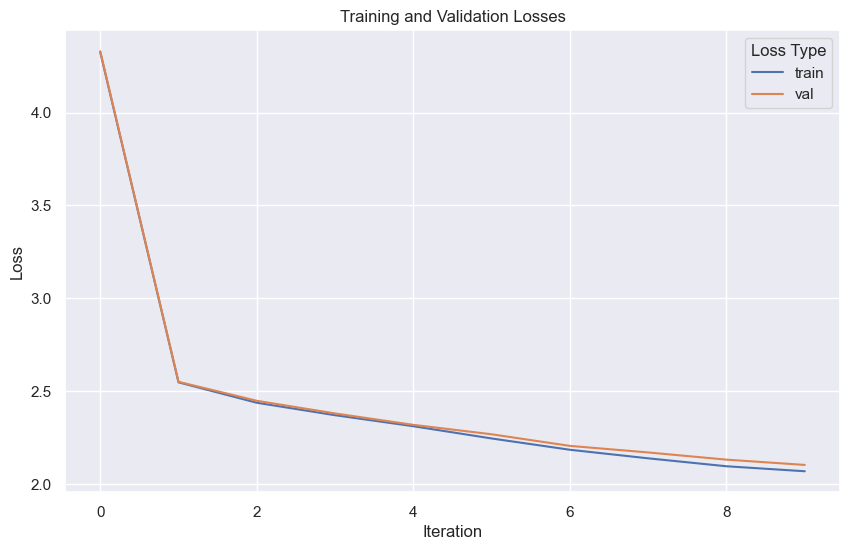

In [16]:
df = pd.DataFrame({
    'iter': range(len(all_losses[DataSplit.TRAIN])),
    'train': all_losses[DataSplit.TRAIN],
    'val': all_losses[DataSplit.VALIDATION]
})

# Melt the DataFrame to create a "long-form" DataFrame
df_melted = pd.melt(df, id_vars=['iter'], value_vars=['train', 'val'],
                    var_name='loss_type', value_name='loss')

# Create the plot
sns.set_theme()
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_melted, x='iter', y='loss', hue='loss_type')

plt.title('Training and Validation Losses')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(title='Loss Type')

plt.show()

In [17]:
torch.save(model, 'weights/tinyGPT.pb')